<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#PSD-to-NPY" data-toc-modified-id="PSD-to-NPY-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>PSD to NPY</a></span></li><li><span><a href="#PNG-to-NPY" data-toc-modified-id="PNG-to-NPY-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>PNG to NPY</a></span></li><li><span><a href="#Extract-Objects" data-toc-modified-id="Extract-Objects-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extract Objects</a></span></li></ul></div>

In [3]:
%reload_ext autoreload
%autoreload 2

from tqdm import tqdm

import activity.image_conversions as imcc

import numpy as np
from glob import glob
from pathlib import Path
from skimage import io, transform, morphology, util
from PIL import Image, ImageOps
from psd_tools import PSDImage

from activity.segmentation import get_segmentation_mask, get_segments, size_filter_SEGS

from joblib import Parallel, delayed

import warnings
warnings.filterwarnings("ignore")

import multiprocessing
cpus = multiprocessing.cpu_count()
print("Nr. of CPU cores: ", cpus)

from matplotlib import pylab as plt

def mCPU(func, var, n_jobs=20,verbose=10):
    return Parallel(n_jobs=n_jobs, verbose=verbose)(delayed(func)(i) for i in var)

def get_f(path):
    return sorted(glob(path))

Nr. of CPU cores:  16


## Sources

- https://arxiv.org/pdf/1505.04597.pdf
- https://medium.datadriveninvestor.com/review-cumedvision2-dcan-winner-of-2015-miccai-gland-segmentation-challenge-contest-biomedical-878b5a443560
- https://towardsdatascience.com/review-u-net-biomedical-image-segmentation-d02bf06ca760
- https://medium.datadriveninvestor.com/review-cumedvision2-dcan-winner-of-2015-miccai-gland-segmentation-challenge-contest-biomedical-878b5a443560



# PSD to NPY

In [16]:
psd_file = "data/annotations/PSD/001.psd"
print(psd_file)

data/annotations/PSD/001.psd


In [32]:
def thfilter(image,th=0.):
    mask = np.zeros_like(image)
    mask[image>th] = 1
    return mask

def get_outline(data,radius=2):
    disk = morphology.disk(radius)
    outlines = np.zeros_like(data[0])
    for i in range(1,4):
        outlines += data[1+i].astype(int)-morphology.erosion(data[1+i].astype(int),disk)
    outlines[outlines > 1] = 1
    return outlines

def psd_to_npy(path):
    psd      = PSDImage.open(path)
    image = np.asarray(psd[0].composite(psd.viewbox))[:,:,0].astype(float)
    #image = image-image.min()
    #image = image/image.max()
    
    conta = np.asarray(psd[3].composite(psd.viewbox))[:,:,-1].astype("uint8")/255
    conta = thfilter(conta)
    cells1= np.asarray(psd[4].composite(psd.viewbox))[:,:,-1].astype("uint8")/255
    cells1= thfilter(cells1)
    if len(psd) > 5:
        cells2= np.asarray(psd[5].composite(psd.viewbox))[:,:,-1].astype("uint8")/255
        cells2= thfilter(cells2)
    else:
        cells2= np.zeros_like(cells1).astype("uint8")
    
    if len(psd) > 6:
        cells3= np.asarray(psd[6].composite(psd.viewbox))[:,:,-1].astype("uint8")/255
        cells3= thfilter(cells3)
    else:
        cells3= np.zeros_like(cells1).astype("uint8")
    all_layers = np.asarray([image,conta,cells1,cells2,cells3])
    outlines   = get_outline(all_layers)
    return np.asarray([image,conta,cells1,cells2,cells3,outlines])

data = psd_to_npy(psd_file)

Unknown key: b'vowv'
Unknown tagged block: b'vowv', b'\x00\x00\x00\x02'


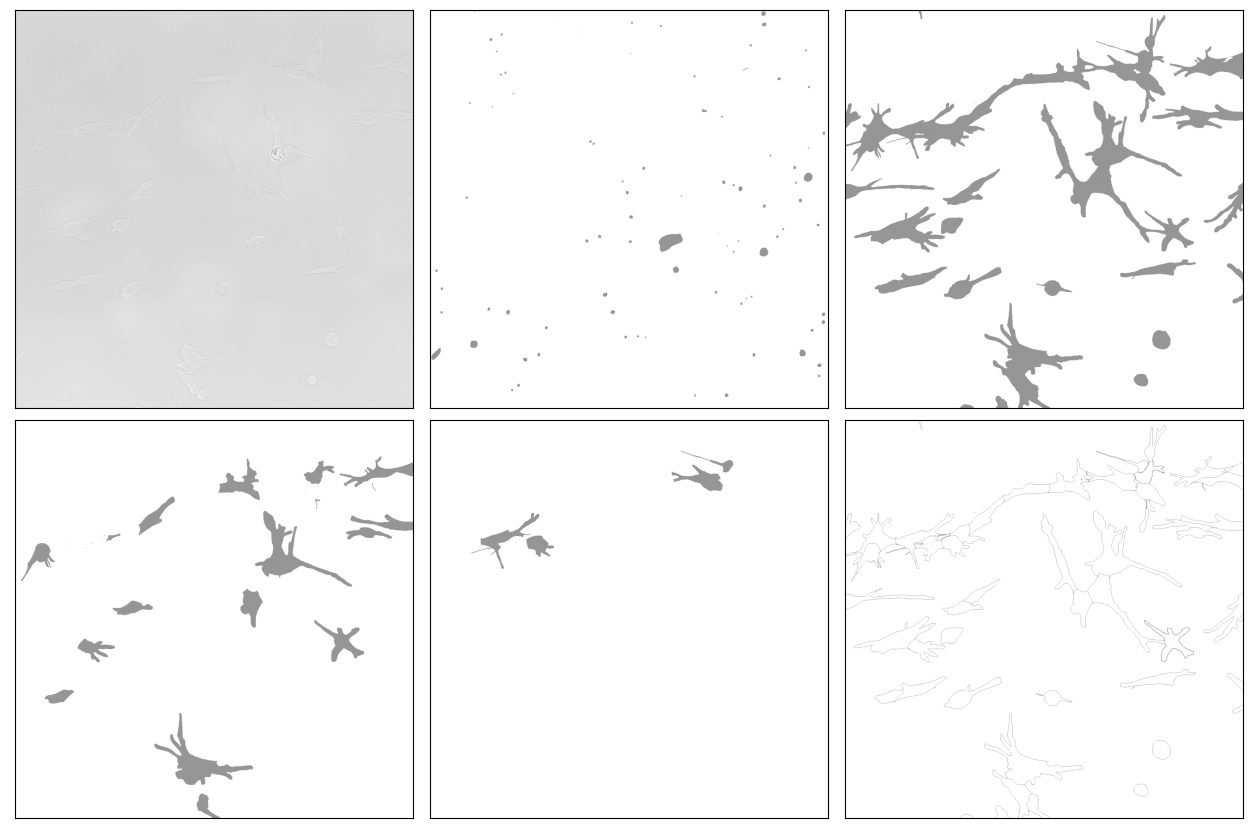

In [41]:
plt.figure(figsize=(16,10.5))
for i in range(len(data)):
    plt.subplot(231+i)
    plt.imshow(data[i,:,:],"Greys",vmax = data[i,:,:].max()*2)
    plt.xticks([]), plt.yticks([])
plt.subplots_adjust(hspace=0.03,wspace=0.012)
plt.show()

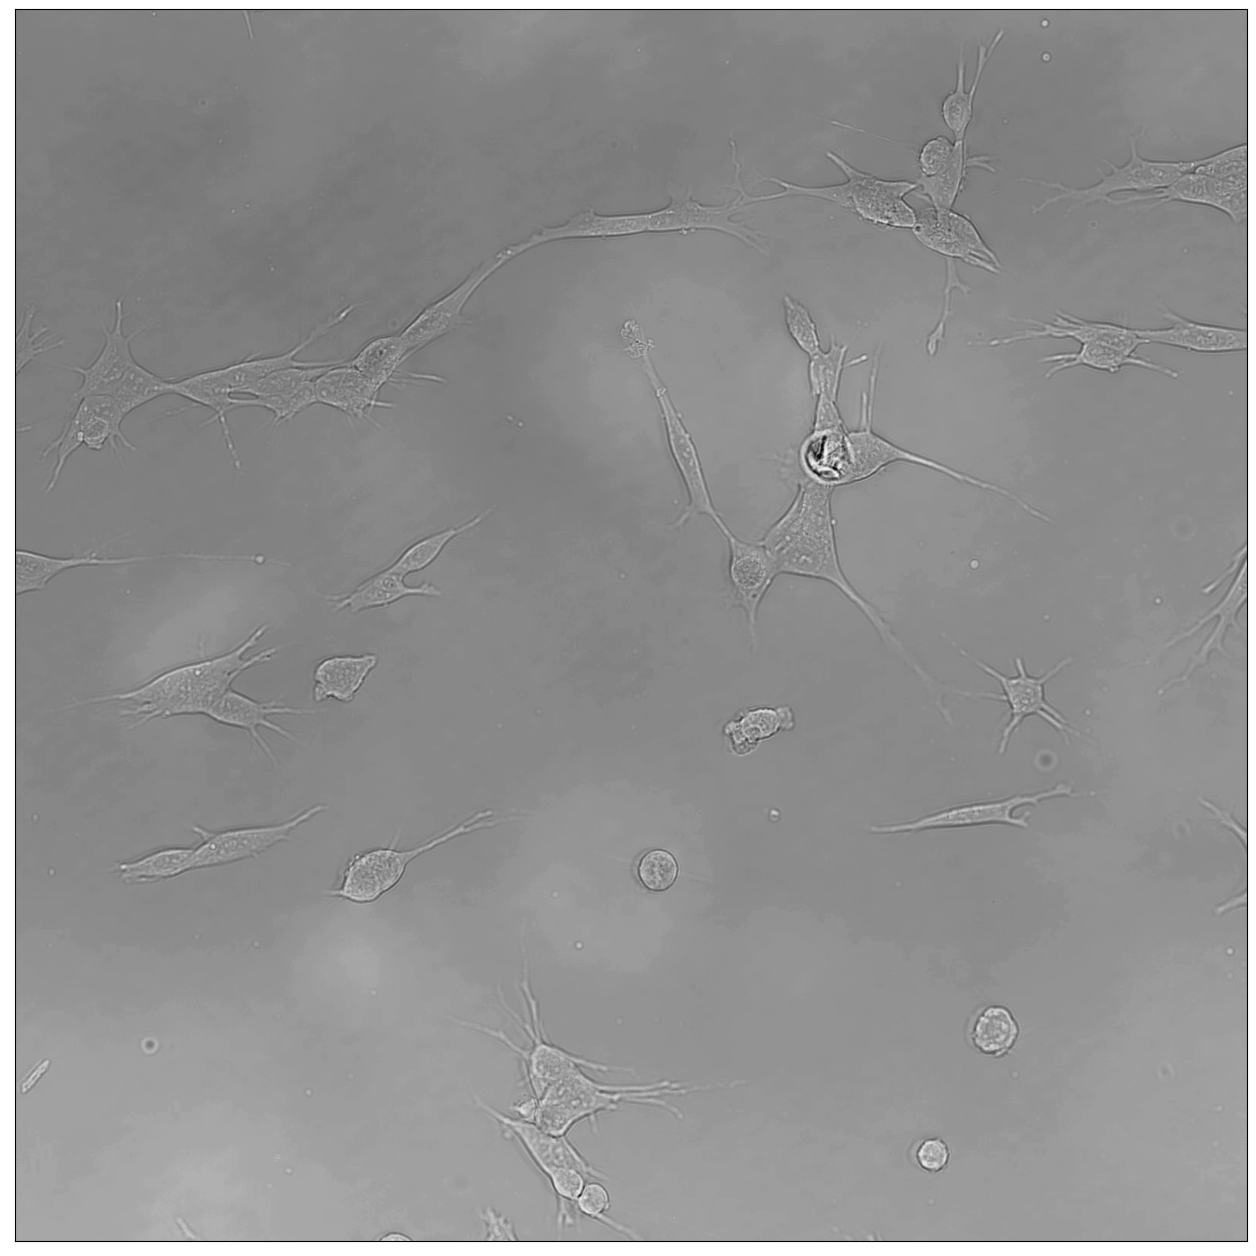

In [19]:
plt.figure(figsize=(16,16))
plt.imshow(data[0],"Greys")
plt.xticks([]), plt.yticks([])
plt.show()

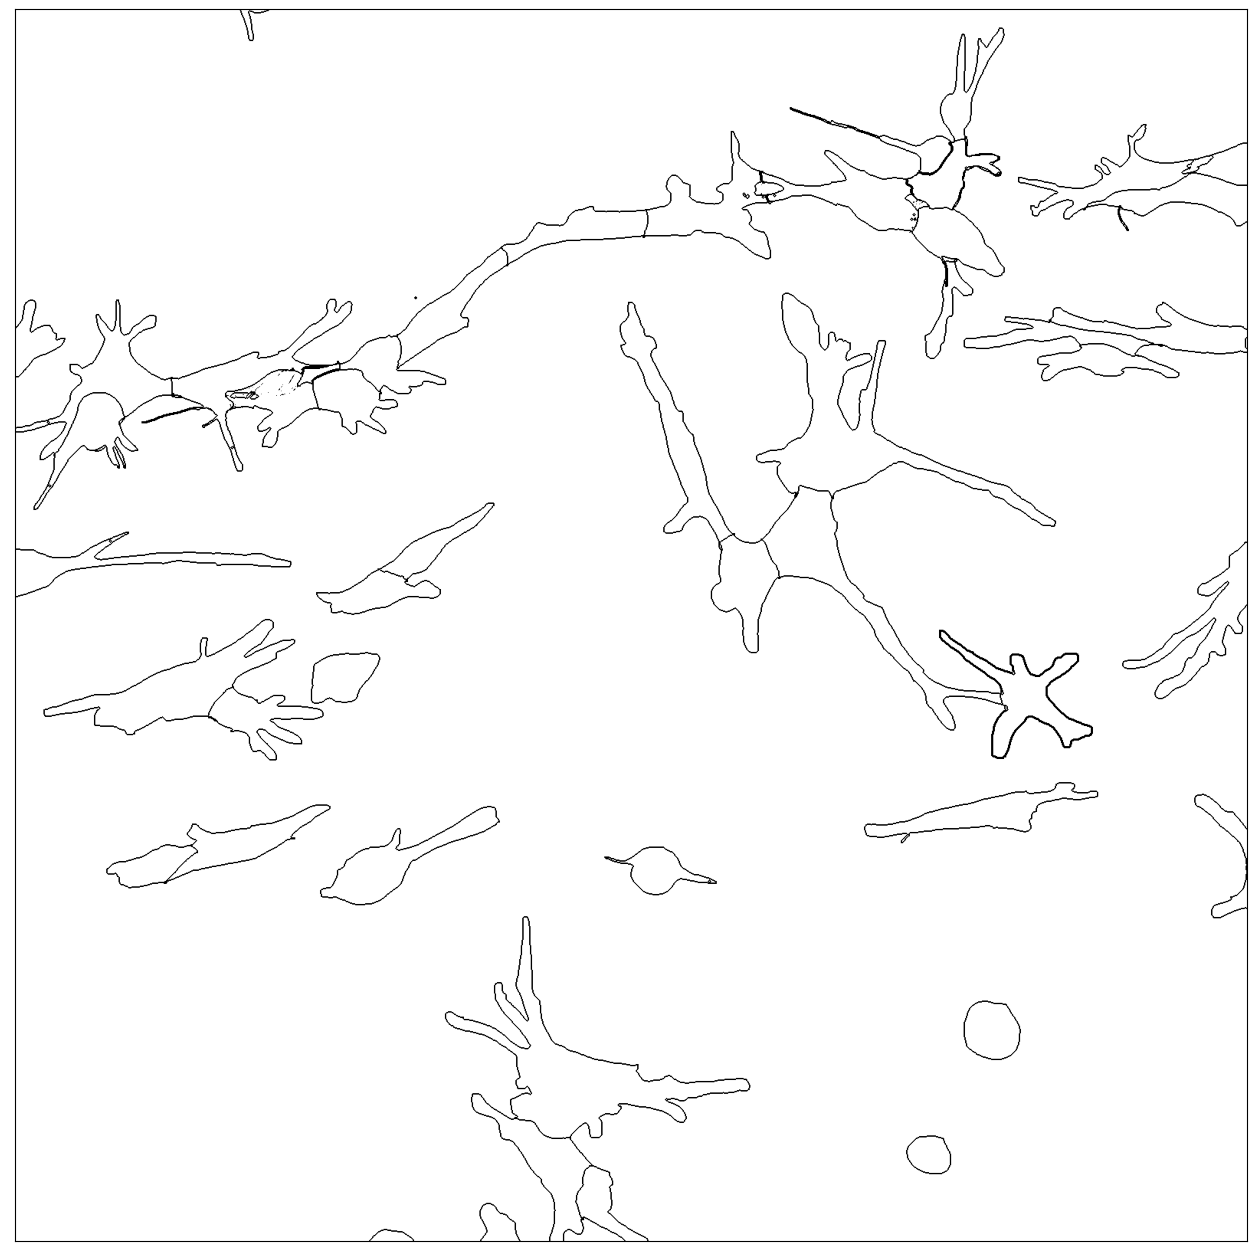

In [42]:
plt.figure(figsize=(16,16))
plt.imshow(data[-1],"Greys")
plt.xticks([]), plt.yticks([])
plt.show()

1: outline
2: contamination
3: cell
4: contamination - cell


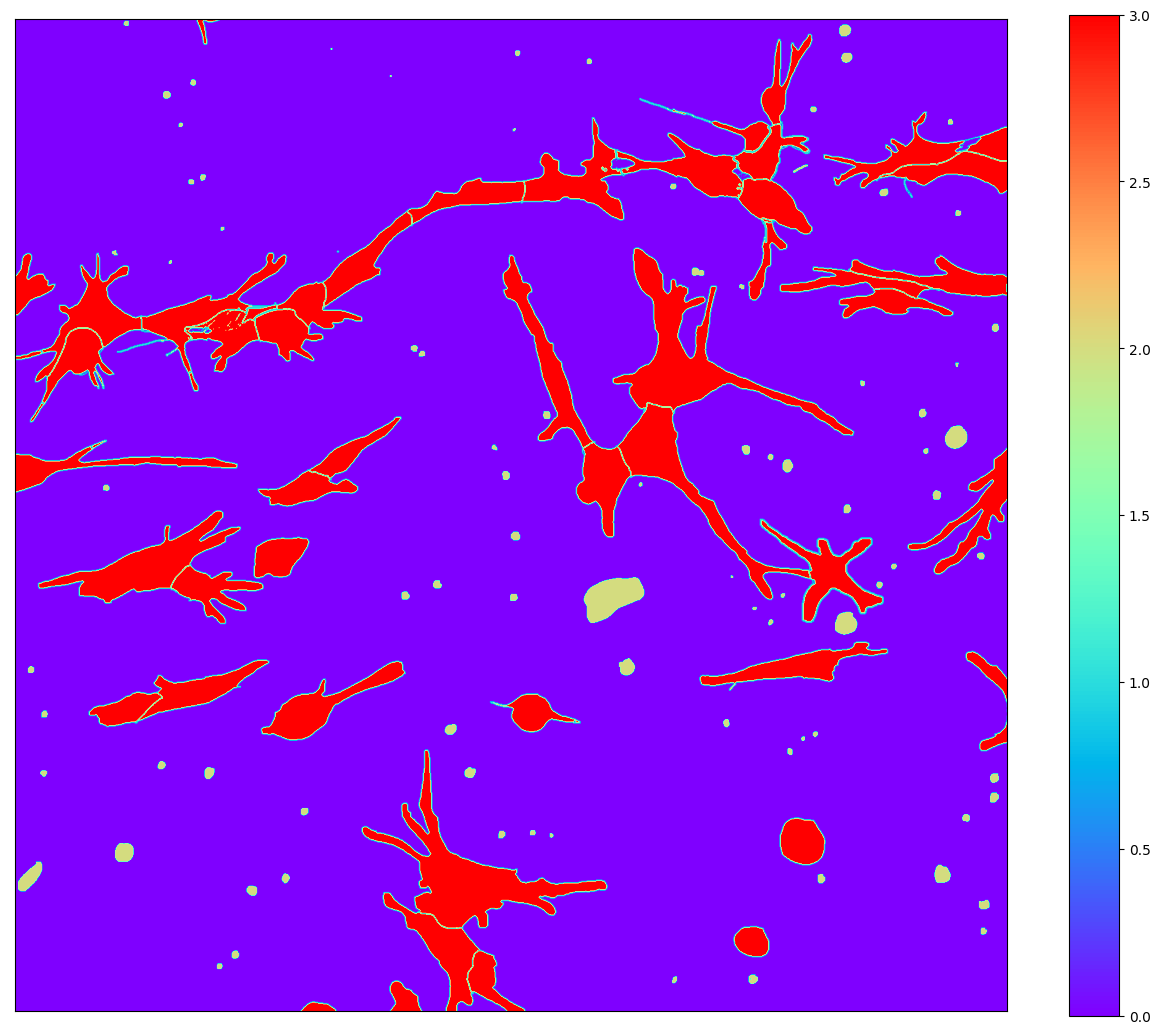

In [43]:
def npy_to_mask(data):
    mask  = data[1]*2
    mask += data[2]*3
    mask[mask>4] = 4
    mask[data[-1]==1] = 1
    return mask.astype(int)

mask = npy_to_mask(data)

print("1: outline")
print("2: contamination")
print("3: cell")
print("4: contamination - cell")


plt.figure(figsize=(16,13))
plt.imshow(mask,cmap="rainbow")
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.show()

1: outline (not used)
2: contamination
3: cell (Level 1)
4: contamination - cell (Level 1)
5: cell (Level 2)
6: contamination - cell (Level 2)
7: cell (Level 3)
8: contamination - cell (Level 3)


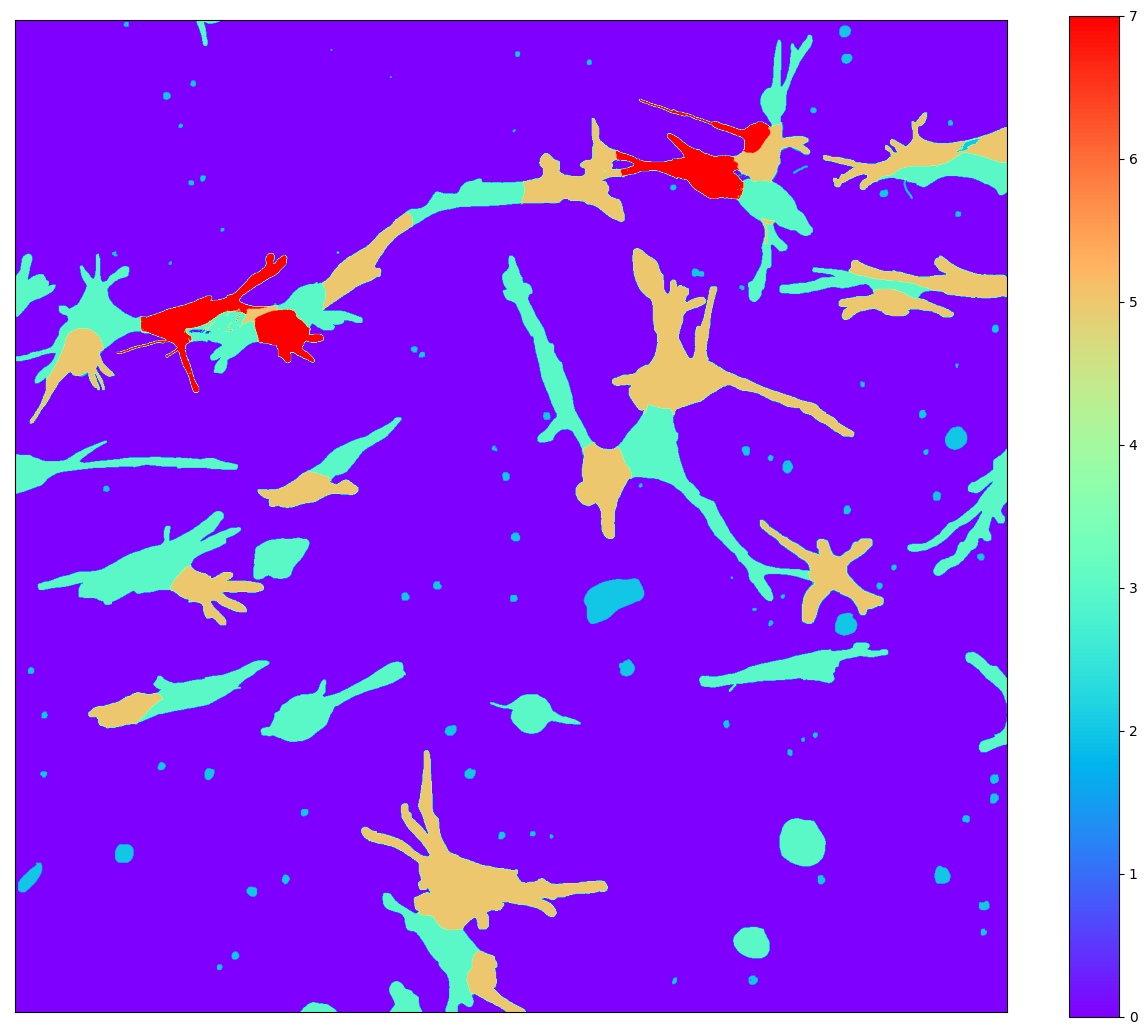

In [44]:
def npy_to_mask_levels(data):
    mask  = data[1]*2
    mask += data[2]*3
    mask[mask>4] = 4
    
    diff = data[3]+data[4]
    diff[diff>1] = -1
    diff[diff>0] = 0
    mask += data[3]*2
    mask += (data[4]+diff)*4
    #mask[data[-1]==1] = 1
    mask[mask>8] = 8
    return mask.astype(int)

mask = npy_to_mask_levels(data)

print("1: outline (not used)")
print("2: contamination")
print("3: cell (Level 1)")
print("4: contamination - cell (Level 1)")
print("5: cell (Level 2)")
print("6: contamination - cell (Level 2)")
print("7: cell (Level 3)")
print("8: contamination - cell (Level 3)")

plt.figure(figsize=(16,13))
plt.imshow(mask,cmap="rainbow")
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.show()

In [45]:
data  = psd_to_npy(psd_file)
mask4 = npy_to_mask(data)



Unknown key: b'vowv'
Unknown tagged block: b'vowv', b'\x00\x00\x00\x02'


In [46]:
def get_tiles(image,size=640, tiles=300):
    images = util.shape.view_as_windows(image,(size,size),tiles)
    return images.reshape(-1,size,size)

maskcrops = get_tiles(mask4,size=320, tiles=600)
imagcrops = get_tiles(data[0],size=320, tiles=600)

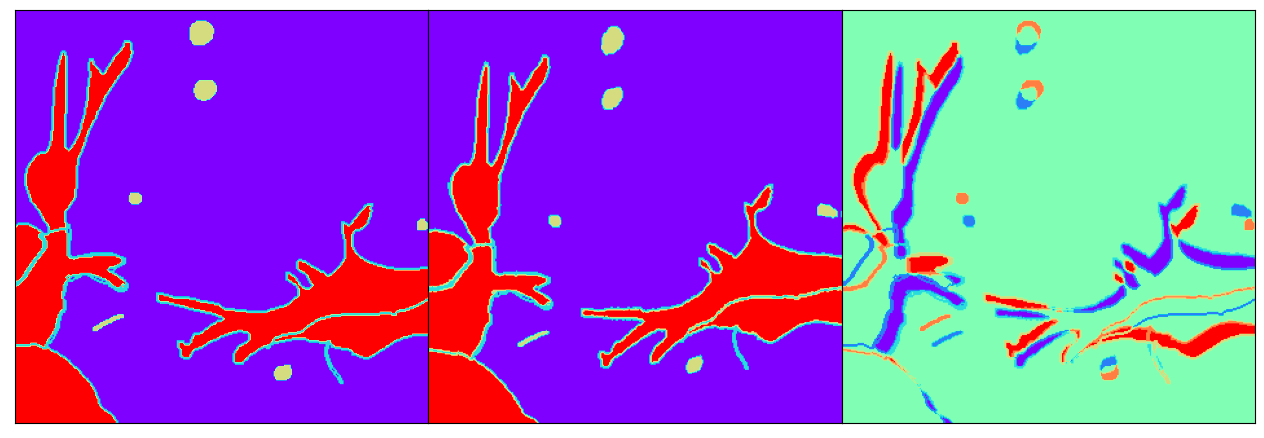

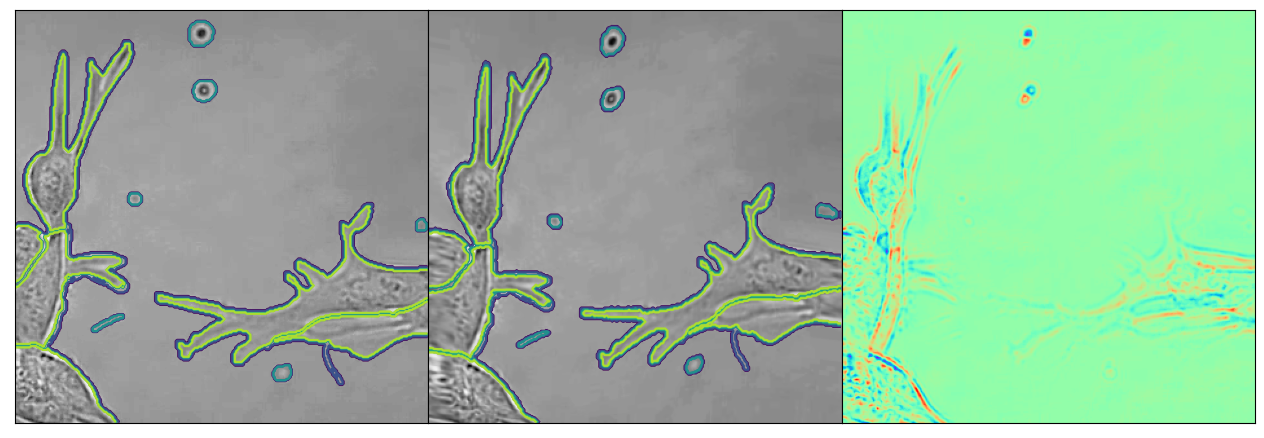

In [47]:
def create_dist_maps(size=640):
    def rd(dxy):
        return (np.random.rand())
    
    src_cols = np.linspace(0, size, 20)
    dxy      = src_cols[1]
    src_rows, src_cols = np.meshgrid(src_cols, src_cols)
    src = np.dstack([src_cols.flat, src_rows.flat])[0]
    
    dst = []
    #for i in src:
    #    duo = []
    #    for j in i:
    #        if j == 0 or j == src.max():
    #            duo.append(j)
    #        else:
    #            duo.append(j+rd(dxy))
    #    dst.append(duo)
    dst_rows = src[:, 1] - np.sin(np.linspace(0,   2*rd(dxy)*np.pi, src.shape[0])) * 10
    dst_cols = src[:, 0] - np.cos(np.linspace(0,   2*rd(dxy)*np.pi, src.shape[0])) * 10
    #dst_rows *= 1.5
    #dst_rows -= 1.5 * 50
    dst = np.vstack([dst_cols, dst_rows]).T
    
    mins0 = np.argwhere(src[:,0]==0)
    mins1 = np.argwhere(src[:,1]==0)
    maxs0 = np.argwhere(src[:,0]==src.max())
    maxs1 = np.argwhere(src[:,1]==src.max())
    
    dst = np.asarray(dst)
    dst[:,0][mins0] = 0 
    dst[:,1][mins1] = 0 
    dst[:,0][maxs0] = src.max()
    dst[:,1][maxs1] = src.max()
    
    #plt.figure(figsize=(10,10))
    #plt.imshow(np.zeros((size,size)),cmap="Greys")
    #plt.plot(src[:, 0],src[:, 1], '.r')
    #plt.plot(dst[:, 0],dst[:, 1], '.b')
    #plt.show()

    return [src, dst]

def distortions(image, maps,size=320):
    
    def shift_left(xy):
        xy[:, 0] += 20
        return xy
    
    src, dst = maps
    tform    = transform.PiecewiseAffineTransform()
    tform.estimate(src, dst)
    
    dist = transform.warp(image, tform, output_shape=image.shape,
                          preserve_range=True,mode='reflect')
    dist = transform.swirl(dist, rotation=0, strength=0.5, 
                           radius=size,preserve_range=True,mode='reflect')

    return dist

maps  = create_dist_maps(size=320)

ind       = 2
dmaskcrop = np.round(distortions(maskcrops[ind],maps),0).astype(int)
dimagcrop = distortions(imagcrops[ind],maps)

plt.figure(figsize=(16,6))
plt.subplot(131)
plt.imshow(maskcrops[ind],"rainbow")
plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(dmaskcrop,"rainbow")
plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(maskcrops[ind]-dmaskcrop,"rainbow")
plt.xticks([]), plt.yticks([])
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

plt.figure(figsize=(16,6))
plt.subplot(131)
plt.imshow(imagcrops[ind],"Greys_r")
plt.contour(maskcrops[ind])
plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(dimagcrop,"Greys_r")
plt.contour(dmaskcrop)
plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(imagcrops[ind]-dimagcrop,"rainbow")
plt.xticks([]), plt.yticks([])
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

In [ ]:
size    = 320
out_dic = "data/anno"
Path(out_dic).mkdir(parents=True, exist_ok=True)
def augment(i):
    data  = psd_to_npy(i)
    mask4 = npy_to_mask(data)
    maskcrops = get_tiles(mask4  ,size, tiles=100)
    imagcrops = get_tiles(data[0],size, tiles=100)
    
    for j in tqdm(range(len(maskcrops))):
        maps  = create_dist_maps(size=320)
        dmaskcrop = np.round(distortions(np.rot90(maskcrops[j]),maps),0).astype(int)
        dimagcrop = distortions(np.rot90(imagcrops[j]),maps)
        if np.random.random() > 0.5:        
            dmaskcrop = np.round(np.rot90(dmaskcrop),0).astype(int)
            dimagcrop = np.rot90(dimagcrop)
        outdata   = np.dstack([dimagcrop,dmaskcrop])
        np.save(out_dic+i.split("/")[-1].replace(".psd","")+"_"+str(int(1000001+j))[1:],outdata)
    data      = None
    mask4     = None
    maskcrops = None
    imagcrops = None
    return 0

augment(psd_file)
#for multiple files
#_ = mCPU(augment_stuff,psd_files,len(psd_files))    